In [1]:
%env CUDA_VISIBLE_DEVICES=1,2,3

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
import argparse
import os
import os.path as osp
import numpy as np
import torch  # put this before scipy import
from scipy.misc import imread, imresize
import sys
sys.path.append(os.path.join(sys.path[0],'..','tools'))

from mattnet import MattNet

print(torch.cuda.current_device())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(2))

env: CUDA_VISIBLE_DEVICES=1,2,3


../tools/mattnet.py:7: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python2.7/runpy.py", line 162, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/imatge/alba.herrera/maskMattnet/MAttNet/venv2/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/imatge/alba.herrera/maskMattnet/MAttNet/venv2/local/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/imatge/alba.herrera/maskMattnet/MAttNet/venv2/local/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 499,

0
3
GeForce GTX TITAN X


In [2]:
# box functions
def xywh_to_xyxy(boxes):
    """Convert [x y w h] box format to [x1 y1 x2 y2] format."""
    return np.hstack((boxes[:, 0:2], boxes[:, 0:2] + boxes[:, 2:4] - 1))

def show_attn(img_path, box, attn):
    """
    box : [xywh]
    attn: 49
    """
    img = imread(img_path)
    attn = np.array(attn).reshape(7,7)
    x,y,w,h = int(box[0]), int(box[1]), int(box[2]), int(box[3])
    roi = img[y:y+h-1, x:x+w-1]
    attn = imresize(attn, [h,w])
    plt.imshow(roi)
    plt.imshow(attn, alpha=0.7)
    
def show_boxes(img_path, boxes, colors, texts=None, masks=None):
    # boxes [[xyxy]]
    img = imread(img_path)
    plt.imshow(img)
    ax = plt.gca()
    for k in range(boxes.shape[0]):
        box = boxes[k]
        xmin, ymin, xmax, ymax = list(box)
        coords = (xmin, ymin), xmax - xmin + 1, ymax - ymin + 1
        color = colors[k]
        ax.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        if texts is not None:
            ax.text(xmin, ymin, texts[k], bbox={'facecolor':color, 'alpha':0.5})
    # show mask
    if masks is not None:
        for k in range(len(masks)):
            mask = masks[k]
            m = np.zeros( (mask.shape[0], mask.shape[1], 3))
            m[:,:,0] = 0; m[:,:,1] = 0; m[:,:,2] = 1.
            ax.imshow(np.dstack([m*255, mask*255*0.4]).astype(np.uint8)) 
            
def save_masks(path, query, masks):
    # show mask
    fig = plt.figure()
    ax = plt.gca()
    for k in range(len(masks)):
        mask = masks[k]
        ax.imshow(mask*255, cmap ='gray') 
        result = Image.fromarray((mask * 255).astype(np.uint8))
        result.save(osp.join(path, query, str(k) + '.jpg'))

In [3]:
# arguments
parser = argparse.ArgumentParser()
parser.add_argument('--dataset', type=str, default='refcoco', help='dataset name: refclef, refcoco, refcoco+, refcocog')
parser.add_argument('--splitBy', type=str, default='unc', help='splitBy: unc, google, berkeley')
parser.add_argument('--model_id', type=str, default='mrcn_cmr_with_st', help='model id name')
args = parser.parse_args('')

In [4]:
# MattNet
mattnet = MattNet(args)

/imatge/alba.herrera/maskMattnet/MAttNet/venv2/local/lib/python2.7/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'layers.joint_match.JointMatching' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/imatge/alba.herrera/maskMattnet/MAttNet/venv2/local/lib/python2.7/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'torch.nn.modules.sparse.Embedding' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/imatge/alba.herrera/maskMattnet/MAttNet/venv2/local/lib/python2.7/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'torch.nn.modu

MatNet [refcoco_unc's mrcn_cmr_with_st] loaded in 4.07 seconds.
Using config:
{'ANCHOR_RATIOS': [0.5, 1, 2],
 'ANCHOR_SCALES': [4, 8, 16, 32],
 'DATA_DIR': '/imatge/alba.herrera/maskMattnet/MAttNet/pyutils/mask-faster-rcnn/data',
 'EXP_DIR': 'res101',
 'MASK_SIZE': 14,
 'MATLAB': 'matlab',
 'MOBILENET': {'DEPTH_MULTIPLIER': 1.0,
               'FIXED_LAYERS': 5,
               'REGU_DEPTH': False,
               'WEIGHT_DECAY': 4e-05},
 'PIXEL_MEANS': array([[[102.9801, 115.9465, 122.7717]]]),
 'POOLING_ALIGN': False,
 'POOLING_MODE': 'crop',
 'POOLING_SIZE': 7,
 'RESNET': {'FIXED_BLOCKS': 1, 'MAX_POOL': False},
 'RNG_SEED': 3,
 'ROOT_DIR': '/imatge/alba.herrera/maskMattnet/MAttNet/pyutils/mask-faster-rcnn',
 'TEST': {'BBOX_REG': True,
          'HAS_RPN': True,
          'MAX_SIZE': 1000,
          'MODE': 'nms',
          'NMS': 0.3,
          'PROPOSAL_METHOD': 'gt',
          'RPN_NMS_THRESH': 0.7,
          'RPN_POST_NMS_TOP_N': 300,
          'RPN_PRE_NMS_TOP_N': 6000,
          

../tools/../pyutils/mask-faster-rcnn/lib/model/config.py:362: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  yaml_cfg = edict(yaml.load(f))


Done (t=0.79s)
creating index...
index created!
pretrained-model loaded from [../tools/../lib/mrcn/../../pyutils/mask-faster-rcnn/output/res101/coco_2014_train_minus_refer_valtest+coco_2014_valminusminival/notime/res101_mask_rcnn_iter_1250000.pth].
Mask R-CNN: imdb[coco_minus_refer], tag[notime], id[res101_mask_rcnn_iter_1250000] loaded in 5.39 seconds.


In [10]:
#query
query = 'bear'
davis = 'DAVIS16'

# image path
IMAGE_DIR = '../../datasets/'
img_path = osp.join(IMAGE_DIR, davis, 'JPEGImages/480p/', query, str(0).zfill(5) + '.jpg')

../tools/../pyutils/mask-faster-rcnn/lib/nets/network.py:237: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  rpn_cls_prob_reshape = F.softmax(rpn_cls_score_reshape)  # batch * 2 * (num_anchors*h) * w
../tools/../pyutils/mask-faster-rcnn/lib/nets/network.py:275: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  cls_prob = F.softmax(cls_score)
/imatge/alba.herrera/maskMattnet/MAttNet/venv2/lib/python2.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


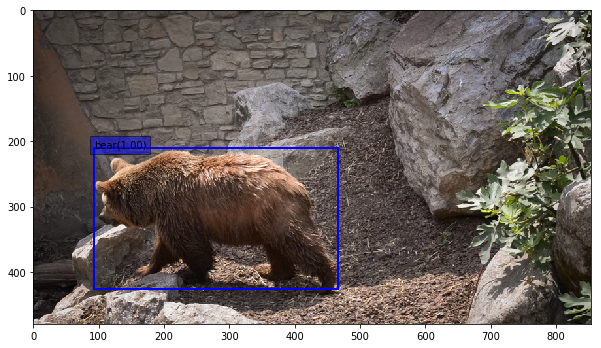

In [11]:
# forward image
img_data = mattnet.forward_image(img_path, nms_thresh=0.3, conf_thresh=0.50)
# show masks
plt.rcParams['figure.figsize'] = (10., 8.)
dets = img_data['dets']
show_boxes(img_path, xywh_to_xyxy(np.array([det['box'] for det in dets])), 
           ['blue']*len(dets), ['%s(%.2f)' % (det['category_name'], det['score']) for det in dets])

In [12]:
# comprehend expression
expr = ''
annot = 'annot1'
annotation_file = 'Davis16_' + annot + '.txt'

# Open the file with read only permit
f = open('../../datasets/davis_text_annotations/' + annotation_file)
for line in f:
    parts = line.split(' ')
    if parts[0] == query:
        print(parts)
        expr = ' '.join(parts[2:]).replace('"', '').strip() # expr = 'man in black'
        break
f.close()
print(expr)
entry = mattnet.comprehend(img_data, expr)

['bear', '1', '"a', 'brown', 'bear"\n']
a brown bear


../tools/../lib/layers/joint_match.py:180: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  weights = F.softmax(self.weight_fc(hidden)) # (n, 3)
../tools/../lib/layers/lang_encoder.py:102: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attn = F.softmax(cxt_scores)  # (batch, seq_len), attn.sum(1) = 1.
../tools/../lib/layers/visual_encoder.py:108: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attn = F.softmax(attn.view(batch, grids)) # (n, 49)


sub(0.72): (a,0.07)(brown,0.47)(bear,0.46)
loc(0.27): (a,0.39)(brown,0.41)(bear,0.20)
rel(0.01): (a,0.55)(brown,0.34)(bear,0.10)
[(u'animal', 0.896354615688324), (u'baby', 0.3510172665119171), (u'black', 0.0785633772611618), (u'dark', 0.07433208078145981), (u'brown', 0.0408320277929306)]


/imatge/alba.herrera/maskMattnet/MAttNet/venv2/lib/python2.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/imatge/alba.herrera/maskMattnet/MAttNet/venv2/lib/python2.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  # This is added back by InteractiveShellApp.init_path()
/imatge/alba.herrera/maskMattnet/MAttNet/venv2/lib/python2.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  from ipykernel import kernelapp as app


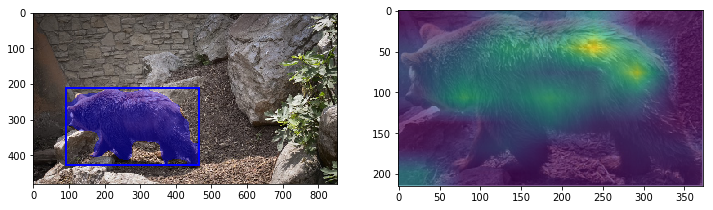

In [13]:
# visualize
tokens = expr.split()
print('sub(%.2f):' % entry['weights'][0], ''.join(['(%s,%.2f)'% (tokens[i], s) for i, s in enumerate(entry['sub_attn'])]))
print('loc(%.2f):' % entry['weights'][1], ''.join(['(%s,%.2f)'% (tokens[i], s) for i, s in enumerate(entry['loc_attn'])]))
print('rel(%.2f):' % entry['weights'][2], ''.join(['(%s,%.2f)'% (tokens[i], s) for i, s in enumerate(entry['rel_attn'])]))
# predict attribute on the predicted object
print(entry['pred_atts'])
# show prediction
plt.rcParams['figure.figsize'] = (12., 8.)
fig = plt.figure()
plt.subplot(121)
show_boxes(img_path, xywh_to_xyxy(np.vstack([entry['pred_box']])), ['blue'], texts=None, masks=[entry['pred_mask']])
plt.subplot(122)
show_attn(img_path, entry['pred_box'], entry['sub_grid_attn'])

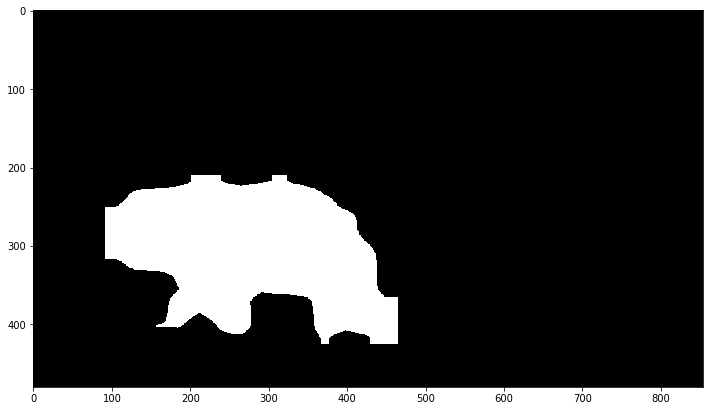

In [14]:
PRED_DIR = '../data/DAVIS16_480p_masks/' + annot
save_masks(PRED_DIR, query, masks=[entry['pred_mask']])